## Clone Dataset

In [1]:
# Cloning dataset from github
!git clone https://github.com/noviaputri/dataset_image.git

Cloning into 'dataset_image'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 483 (delta 12), reused 472 (delta 1), pack-reused 0
Receiving objects: 100% (483/483), 27.13 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (12/12), done.


## Import Library

In [2]:
# Import necessary libraries
import numpy as np
import keras
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Image Generator

In [3]:
# Directories
train_directory = "dataset_image/train"
valid_directory = "dataset_image/val"
test_directory = "dataset_image/test"

# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 50
batch_size = 64
num_of_classes = 3
num_of_train_samples = 362
num_of_valid_samples = 45
num_of_test_samples = 47

# Load Train Data as image generator with Keras, Normalization with (rescale=1./255)
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load Validation Data as image generator with Keras, Normalization with (rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load Test Data as image generator with Keras, Normalization with (rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_directory, 
                                                                        class_mode='categorical', 
                                                                        batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                        shuffle=False)

Found 284 images belonging to 3 classes.
Found 124 images belonging to 3 classes.
Found 46 images belonging to 3 classes.


## Confusion Matrix Plot Function

In [4]:
# Function for plotting the Confusion Matrix
def plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(10,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = np.around(cm, decimals=2)
      cm[np.isnan(cm)] = 0.0
      print("Normalized confusion matrix")

  else:
      print('Confusion matrix, without normalization')

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [5]:
# Function for train the given model and get Confusion Matrix
def trainModelAndGetConfusionMatrix(model):
  # Fit the model
  model.fit_generator(train_generator,
                      epochs=epochs,
                      steps_per_epoch=num_of_train_samples // batch_size,
                      validation_data=valid_generator,
                      validation_steps=num_of_valid_samples // batch_size)

  # Evaluate the model
  loss_and_metrics = model.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
  print("Test Loss: ", loss_and_metrics[0])
  print("Test Accuracy: ", loss_and_metrics[1])
  test_generator.reset()

  # Get Confusion Matrix and plot it
  Y_pred = model.predict_generator(test_generator, steps=num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  class_names = []
  for key in train_generator.class_indices:
      class_names.append(key)

  cr = classification_report(test_generator.classes, y_pred, target_names=class_names)
  print("Classification Report\n" + cr) # Print classification report
  cm = confusion_matrix(test_generator.classes, y_pred)

  plotConfusionMatrix(cm, class_names, normalize=False, title='Confusion Matrix')
  plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion Matrix')

  return model

## Get Feature Function

In [6]:
# Get feature vector of an image by given model and img_path
def getFeatureVector(model, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))

  print(img_path + " is added.")
  return feature_vector

# Get cosine similarity between feature vectors A and B using cosine similarity
def getCosineSimilarity(A, B):
  cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) # Get cosine similarity
  return cos_similarity[0][0]

In [7]:
# Function for get dataframe which contains the output features of given model
def getFeatureDataFrame(model):
  df = pd.DataFrame(columns=['file', 'features'])
  train_files = train_generator.filepaths
  valid_files = valid_generator.filepaths

  files = train_files + valid_files
  print(len(files))

  df['file'] = files
  df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1) 

  print("All files added.")
  return df

## ResNet-50 Model

In [8]:
# Get ResNet-50 Model
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)

  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=3, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True

  # Compile ResNet-50 model
  resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()
  
  return resnet_model

102981632/102967424 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

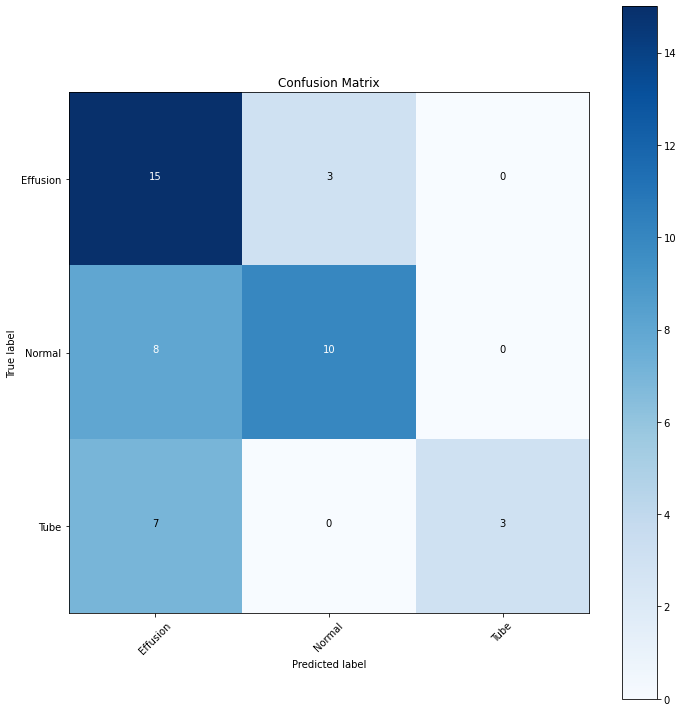

Normalized confusion matrix


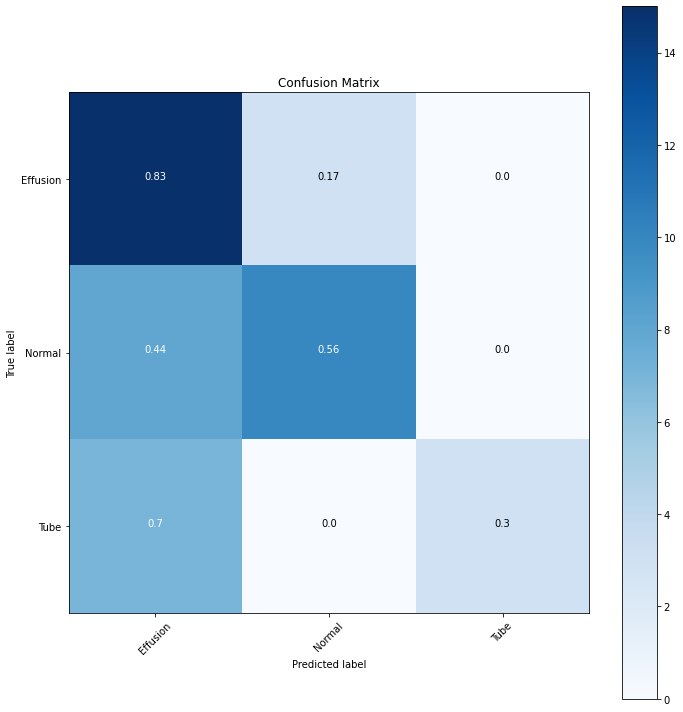

In [9]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model_a = getResNet50Model(lastFourTrainable=False)
# Train ResNet-50 Model and get Confusion Matrix
resnet_model_a = trainModelAndGetConfusionMatrix(resnet_model_a)

In [10]:
# save model
resnet_model_a.save_weights('model_resnet_nontrainable.h5')

## Feature Extraction for Image Retrieval with Weights of ResNet-50

In [11]:
# Get feature extractor model from last layer of resnet_model_a
resnet_model_a = getResNet50Model(lastFourTrainable=False)
resnet_model_a.load_weights('model_resnet_nontrainable.h5')
feature_model_resnet_a = Model(inputs=resnet_model_a.input, outputs=resnet_model_a.get_layer('new_fc').output)

df = getFeatureDataFrame(feature_model_resnet_a)
df.to_pickle("features_resnet_a.pickle")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Get similar image

In [12]:
# Plot similar 5 images with given image and similar images dataframe
import sklearn.metrics as metric
import copy

label_builder = ['Effusion', 'Normal', 'Tube']
class_builder = {label_unique:[] for label_unique in label_builder}
recalls = copy.deepcopy(class_builder)
precisions = copy.deepcopy(class_builder)
accuracies = copy.deepcopy(class_builder)

def plotSimilarImages(img_file, similar_df, model_name):
  img = cv2.imread(img_file)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  split_list = img_file.split('/')
  split_list.reverse()
  img_class = split_list[1]
  fig, axarr = plt.subplots(2,3)
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + model_name + "\nClass: " + img_class)
  axarr[0,0].axis('off')

  #coba
  label_ret = []
  label_true = img_class

  j, k, m = 0, 0, 1
  for index, sim in similar_df.iterrows():
    filepath = sim['file']
    similarity = sim['similarity']
    split_list = filepath.split('/')
    split_list.reverse()
    sim_class = split_list[1]
    label_ret.append(sim_class)

    #eval
    #recall = metric.recall_score(label_trues, labels_ret, average='weighted')
    #precision = metric.precision_score(label_trues, labels_ret, average='weighted')
    #accuracy = metric.accuracy_score(label_trues, labels_ret)

    similar = cv2.imread(filepath)
    similar = cv2.resize(similar, (224, 224))
    similar = cv2.cvtColor(similar, cv2.COLOR_BGR2RGB)
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.3f" % similarity + "\nClass: " + sim_class)
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  label_trues = [label_true for _ in label_ret]
  recall = metric.recall_score(label_trues, label_ret, average='weighted')
  precision = metric.precision_score(label_trues, label_ret, average='weighted')
  accuracy = metric.accuracy_score(label_trues, label_ret)
  recalls[label_true].append(recall)
  precisions[label_true].append(precision)
  accuracies[label_true].append(accuracy)

  plt.tight_layout()
  plt.show()

In [13]:
# Get and plot 5 similar images for given image path and features dataframe
def getSimilarImages(img_file, features_df, model, model_name):
  img_features = getFeatureVector(model, img_file)
  features_df['similarity'] = features_df.apply(lambda row: getCosineSimilarity(img_features, np.asarray(row['features'])), axis=1)  
  sorted_df = features_df.sort_values(by='similarity', ascending=False)
  
  plotSimilarImages(img_file, sorted_df.head(5), model_name)

In [14]:
# Test images path
feature_test_path = 'dataset_image/test'
feature_test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=feature_test_path,
                                                                  class_mode='categorical',
                                                                  batch_size=batch_size,
                                                                  target_size=(img_rows, img_cols),
                                                                  color_mode="rgb",
                                                                  shuffle=False)
feature_test_files = feature_test_generator.filepaths

Found 46 images belonging to 3 classes.


In [15]:
# Get similar images of test images for ResNet-50 (a)
resnet_model_a = getResNet50Model(lastFourTrainable=False)
resnet_model_a.load_weights('model_resnet_nontrainable.h5')
feature_model_resnet_a = Model(inputs=resnet_model_a.input, outputs=resnet_model_a.get_layer('new_fc').output)

df = pd.read_pickle('features_resnet_a.pickle')
for file in feature_test_files:
  getSimilarImages(file, df, feature_model_resnet_a, 'ResNet-50 (a)')

Output hidden; open in https://colab.research.google.com to view.

## Evaluation

In [16]:
print("recall values:")
comb_recall, comb_precision = [], []
for key in recalls.keys():
    average_val = np.average(recalls[key])
    print(key, average_val)
    comb_recall.append(average_val)
print("combined recall", np.average(comb_recall))

print("\nprecision values:")
for key in precisions.keys():
    average_val = np.average(precisions[key])
    print(key, average_val)
    comb_precision.append(average_val)
print("combined precision", np.average(comb_precision))

print("\naccuracy values:")
comb_accuracy = []
for key in accuracies.keys():
    average_val = np.average(accuracies[key])
    print(key, average_val)
    comb_accuracy.append(average_val)
print("combined accuracy", np.average(comb_accuracy))

recall values:
Effusion 0.6555555555555556
Normal 0.8222222222222223
Tube 0.74
combined recall 0.7392592592592594

precision values:
Effusion 0.9444444444444444
Normal 1.0
Tube 1.0
combined precision 0.9814814814814815

accuracy values:
Effusion 0.6555555555555556
Normal 0.8222222222222223
Tube 0.74
combined accuracy 0.7392592592592594
